## Using machine learning to detect credit card fraud


### Introduction

The aim of this project is to train a machine learning model so detect fraudulent 
credit card transactions. Building a robust models is important for protecting customers
from purchases they did not make.

### About the data

The dataset is credited to the Machine Learning Group and Andrea Dal Pozzolo. As seen below, 
the CSV file contains a number of anomynous variables (V1,V2,...), along with **Time** and **Amount**.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./creditcard.csv')
# total transaction
total_trans = df.shape[0]

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Here, the label for the dataset is found in the **Class** column (where fraudulent transactions have class=1). The features are **Time**, **Amount**, **V1**, **V2** and so on. These features are principal components of some variables obtained from PCA. 
We don't know what the original variables for these PCA are, as those data are confidential. But we have two known variables, which are **Time** and **Amount**.

Essentially, the idea here is that a combination of these features will indicate whether a particular transaction
is a fraudulent or not. We can use a supervised learning algorithms as the labels have already been defined. If the labels are not given, we can try to use PCA + K mean clustering to create labels (i.e. identify a subset of suspicious 
transactions) for the dataset.

### Data Cleaning

There are a couple of things we want to do there. 

**FIRST:** The **Time** column isn't that useful for machine learning models, as it appears to just be increasing with each transaction row. So essentially we can just remove this column.

**SECOND:** Looking at the **Amount** column, the values have a wide range, which means that the model might take
a long time to converge to a solution. If we normalize this column, it will help the model train faster.

**THIRD:** We need to check to see if there are any null in the dataset and remove any duplicate data.


In [16]:

from sklearn.preprocessing import StandardScaler


################# drop Time column #####################
try:
    df.drop(labels=['Time'], axis=1, inplace=True)
except:
    print ('Time column has already been removed')

    
########### normalize the Amount column ###############

# create a 2d array of the amounts
amounts = df.Amount.values[:, np.newaxis]
# scale the data so that the mean = 0 and sigma = 1
scaler = StandardScaler()
scaled_amounts = scaler.fit_transform(amounts)

df['Amount'] = scaled_amounts


########### remove NANs and duplicates ###############

# see if there is any null values in each column
print ( df.info() ) # this shows that there are no null values

# drop duplications (by default this code checks for duplicated values across all columns)
df.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [17]:
print ('The number of duplicated values is {}'.format( total_trans-df.shape[0]))

print ('The total number of (non-dupl) transactions are: {}'.format( df.shape[0] ) )
print ('The number of fraudulent transactions are: {}'.format( len(df[df.Class==1]) ) )
print ('The number of non-fraud transactions are: {}'.format( len(df[df.Class==0]) ))

The number of duplicated values is 9144
The total number of (non-dupl) transactions are: 275663
The number of fraudulent transactions are: 473
The number of non-fraud transactions are: 275190


We have removed around 9000 duplicated transactions. After this, only a small number of transactions are fraudalent.


### Training the model

To begin, we want to separate dataset into a training set and a testing set.

In [18]:
from sklearn.model_selection import train_test_split

# defining the feature columns and the label columns
feat = df.drop('Class', axis = 1).values
labels = df['Class'].values

# separating the data into a training set and a testing set (0.25 of the total data)
feat_train, feat_test, labels_train, labels_test = train_test_split(feat, labels, random_state=0)

print (labels_train.shape)

(206747,)


Picking the right model to train the dataset on is always difficult, and sometimes it would just fall down to the interpretability of the model and how well it can predict correct labels.

In this particular example, the generalized idea here is that a set of features (i.e., Amount, V1, V2 ...) will tell us whether a transaction is fraud or not. If we use a Decision Tree Classifier model, the idea here is that a structured branch is made based on the features so that the model can transverse it to figure out whether subsets of the features correspond to the fraud/non-fraud class.

So let's use the  from sklearn, and test how well the model did.

In [19]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(feat_train,labels_train)

labels_pred = clf.predict(feat_test)

### Testing model's accuracy

A good way to gauge how well the model can classify fraudulent transactions from the testing set is to create the confusion matrix. Essentially, the diagonal of the matrix will tell you how much correct labels the model made, while the off diagonal tells you the number of false negative and false positives.

However, what we are interested in is the number of credit card fraudulent cases which are mislabeled by the model. If a lot of fraud cases are falsely labeled as non-fraud, it would indicate that then the model is not effective at all.


68772 28 29 87


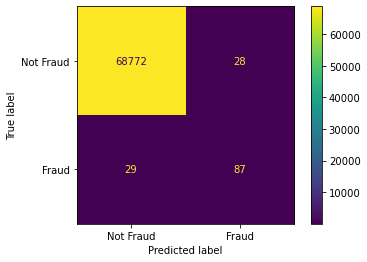

The total number of fraudulent transactions are: 116
The number of fraudulent transactions which are falsely labeled are: 29
The percentage of fraudulent transactions which are correctly labeled are: 0.75


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
                            f1_score, precision_score, recall_score

# confusion matrix
cm = confusion_matrix(labels_test, labels_pred)
tn, fp, fn, tp = cm.ravel()

print (tn, fp, fn, tp)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
cmd_obj.plot()
plt.show()


print ('The total number of fraudulent transactions are: {}'.format( fn+tp  ))
print ('The number of fraudulent transactions which are falsely labeled are: {}'.format( fn ))
# this measurement is basically the recall
print ('The percentage of fraudulent transactions which are correctly labeled are: {}'.format( tp/(fn+tp) ))

As you can see, **only 75%** of fraud transactions are correctly predicted by the model, which is an okay number. This measurement is known as the recall score.

Another metric that we might be interested in is the number of true fraudulent cases in relation to the total 
number of predicted fraudulent case (i.e. precision score), as it can let us gauge at how many fraud transactions are correctly labeled out of all the fraud cases detected by the model. 

We can also use the f1-score, which is the weighted average of precision and recall.

In [21]:
print("Recall:",recall_score(labels_test, labels_pred))
print("Precision:",precision_score(labels_test, labels_pred))
print("F1-score:",f1_score(labels_test, labels_pred))

Recall: 0.75
Precision: 0.7565217391304347
F1-score: 0.7532467532467532


### Random Forest Classifier

While using the Decision Tree model, only a single decision "tree" is made, which may not be sufficient to make an effective model. However, we can push this tree model idea a bit further by using a Random Forest Classifier model. The idea is similar, but instead of making one decisison tree, the Random Forest Classifier model creates multiple trees for random subsets of the dataset and then average them to improve on the predictive accurary.

We can train the model to see how well it compares to the Decision Tree model. 

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(feat_train,labels_train)

labels_pred = clf.predict(feat_test)

68796 4 29 87


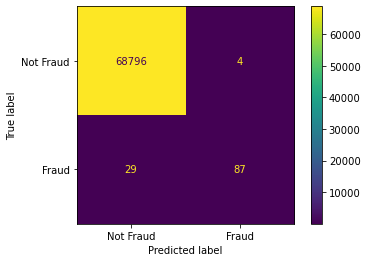

Recall: 0.75
Precision: 0.9560439560439561
F1-score: 0.8405797101449275


In [23]:
# confusion matrix
cm = confusion_matrix(labels_test, labels_pred)
tn, fp, fn, tp = cm.ravel()

print (tn, fp, fn, tp)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
cmd_obj.plot()
plt.show()

print("Recall:",recall_score(labels_test, labels_pred))
print("Precision:",precision_score(labels_test, labels_pred))
print("F1-score:",f1_score(labels_test, labels_pred))

So we can see that we have improved the precision of the model by quite a lot. This means that we are less likely to flag non-fraud transactions as fraudulent and keep customers happy. However, the model still can't predict fraudulent transactions effectively (i.e. the recall score) - only three quarters of fraud transactions are correctly identified. 

This issue could be related to an **imbalanced in the dataset**, as the majority of the labels are non-fraud (>20000) and a minority of the labels are fraud (<500). 

We can try to use sampling techniques to try to balance out the two labels. Here, SMOTE is a resampling technique from the Python library **imbalance-learned**. It uses the minority class in order to generate synethic observations in order to create more samples of fraudulent transactions. We can see at the end, both the metric for the recall and precision is close to zero, indicating the model is very effective.

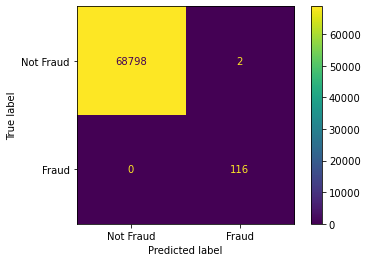

Recall: 1.0
Precision: 0.9830508474576272
F1-score: 0.9914529914529915


In [25]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
# oversample the fraud class and generate new dataset with syntheic observations
over_feat, over_labels = oversample.fit_resample(feat, labels)
# split the new dataset to a training and testing set
over_feat_train, over_feat_test, over_labels_train, over_labels_test = train_test_split(over_feat, over_labels)

#Build SMOTE Random Forest model
SMOTE_RF = RandomForestClassifier(random_state=0)
SMOTE_RF = SMOTE_RF.fit(over_feat_train, over_labels_train)

# we want to test on the real transactions
labels_pred = SMOTE_RF.predict(feat_test)

# confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
cmd_obj.plot()
plt.show()

print("Recall:",recall_score(labels_test, labels_pred))
print("Precision:",precision_score(labels_test, labels_pred))
print("F1-score:",f1_score(labels_test, labels_pred))

